In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import helpers
import pandas as pd
from skimage import exposure
from PIL import Image
from scipy import ndimage
from skimage.measure import label, regionprops_table, regionprops
from skimage import util
from skimage import filters

In [46]:
# filename = 'benoitdata/F20-14A/HA-900_6um_jamtveit_att_pag-2.29_3.40_02043.tif'
# filename = 'benoitdata/F20-11/HA-900_6um_jamtveit_att_pag-2.29_3.40_05665.tif'
filename = 'benoitdata/F20-11/HA-900_6um_jamtveit_att_pag-2.29_3.40_09224.tif'
img = cv2.imread(filename,0)

(90.0, 140.0)

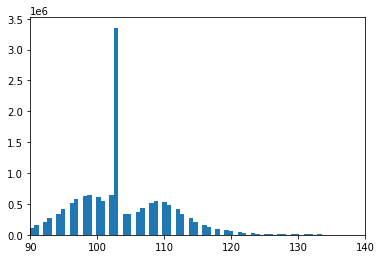

In [47]:
plt.hist(img.ravel(), bins=256)
plt.xlim(90, 140)

In [91]:
def label_fractures(img):
    img_remove = helpers.remove_data_based_on_radius(img, mask_value=np.nan)
#     img_remove = remove_data_based_on_radius(img, mask_value=np.nan)
    zim = helpers.zscore(img_remove)
#     zim = zscore(img_remove)
    zim_remove = zim.copy()
    zim_remove[zim_remove > -2] = 0
    
    x1, y1 = zim_remove.nonzero()
    zeros = np.zeros_like(zim_remove)
    zeros[x1, y1] = 1
    return zeros

def median_max(img):
    footprint1 = np.array(
        [[1, 1, 1]
        ,[1, 0, 1]
        ,[1, 1, 1]]
        )
    
    footprint2 = np.array(
        [[1, 1, 1, 1, 1]
        ,[1, 1, 1, 1, 1]
        ,[1, 1, 0, 1, 1]
        ,[1, 1, 1, 1, 1]
        ,[1, 1, 1, 1, 1]]
        )
    # creates a window based on the given footprint
    # to compare neighbors and replace values on 
    # nearest maximum value
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html
    img = ndimage.median_filter(img, footprint=footprint1, mode='constant')
    img = ndimage.maximum_filter(img, footprint=footprint2, mode='constant')
    return img

def remove_convex_area_eccentricity(img, convex_area=60, eccentricity=0.8):
    """
    Removes fractures based on convex area and eccentricity minimum values
    
    convex_area : Number of pixels of convex hull image, which is the smallest convex polygon that encloses the region.

    eccentricity : Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.
    """
    labeled_fracs = label(img)
    df = pd.DataFrame(regionprops_table(labeled_fracs, properties=[ 'convex_area', 'eccentricity', 'label']))
#     img = np.where(np.isin(labeled_fracs, df[(df.convex_area > 60) & (df.eccentricity > 0.8)].label.values), img, np.nan)
#     img = np.where(np.isin(labeled_fracs, df[(df.convex_area > convex_area) & (df.eccentricity > eccentricity)].label.values), img, np.nan)
    img = np.where(np.isin(labeled_fracs, df[(df.eccentricity > eccentricity)].label.values), img, np.nan)
    return img

def convert_to_binary(img):
    ones_i = np.where(np.isnan(img), 0, 1)
    return ones_i

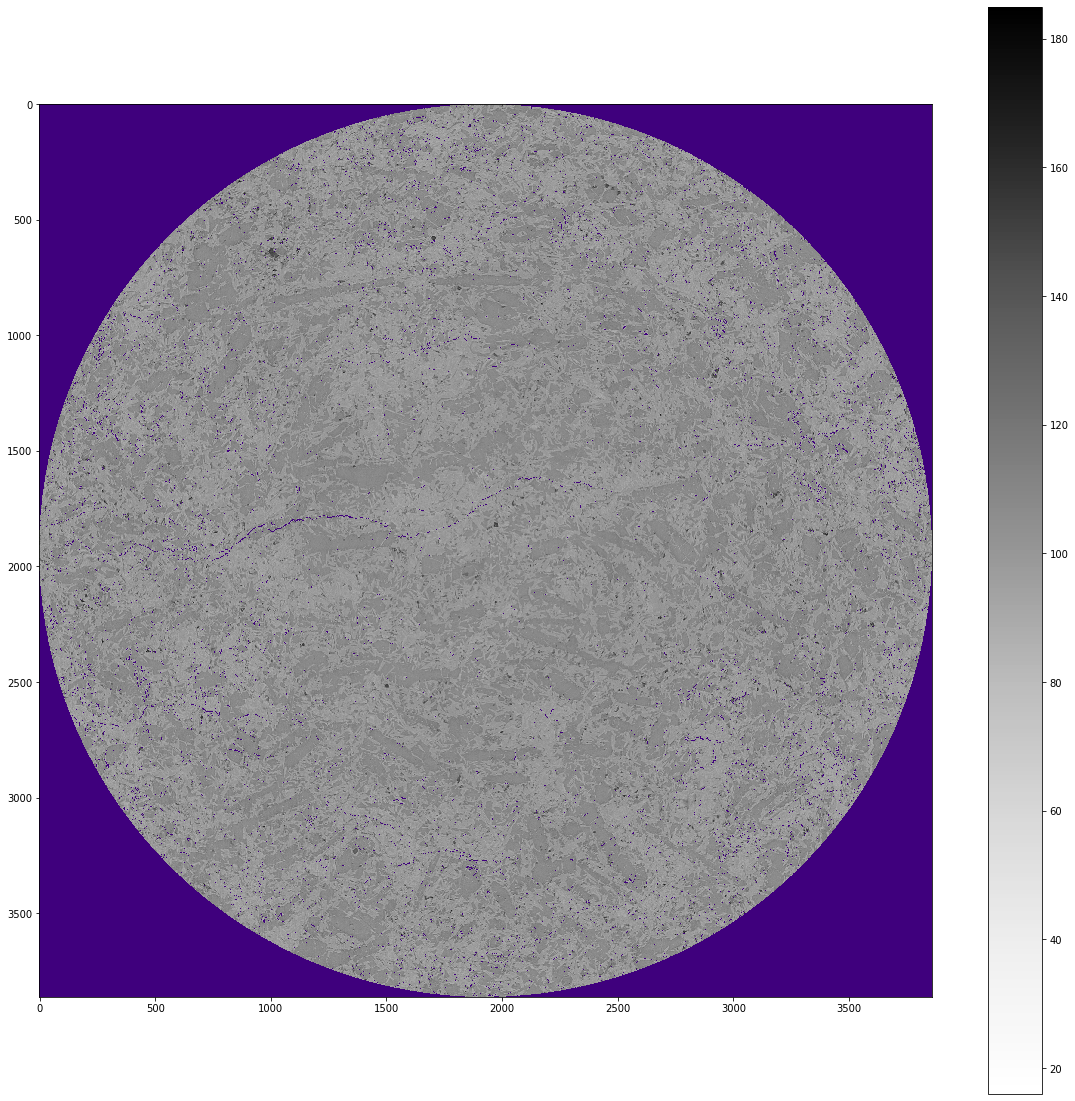

In [168]:
zim = helpers.zscore(helpers.remove_data_based_on_radius(img, np.nan))
# zim = convert_to_binary(zim)
labeled = label_fractures(zim)
# labeled = median_max(labeled)
# labeled = cv2.dilate(labeled, np.ones((5, 5), np.uint8))
# labeled = cv2.erode(labeled, np.ones((7, 7), np.uint8))
# labeled = cv2.morphologyEx(labeled, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))


# labeled = remove_convex_area_eccentricity(labeled, convex_area=0, eccentricity=0.2)

labeled = labeled.astype(np.float32)
labeled[labeled==0] = np.nan

# fig, ax = helpers.plot_image(labeled, interpolation='none', cmap='Purples')
fig, ax = helpers.plot_image(img, interpolation='none', cmap='Greys')
ax.imshow(labeled, interpolation='none', cmap='Purples_r')
# ax.set_xlim(1000, 1500)
# ax.set_ylim(1500, 2000)

In [161]:
np.unique(labeled)

array([ 1., nan, nan, ..., nan, nan, nan], dtype=float32)

In [162]:
labeled = np.nan_to_num(labeled, nan=0)
labeled = helpers.remove_data_based_on_radius(labeled, -1)


In [163]:
np.unique(labeled)

array([-1.,  0.,  1.])

(<Figure size 1440x1440 with 2 Axes>, <AxesSubplot:>)

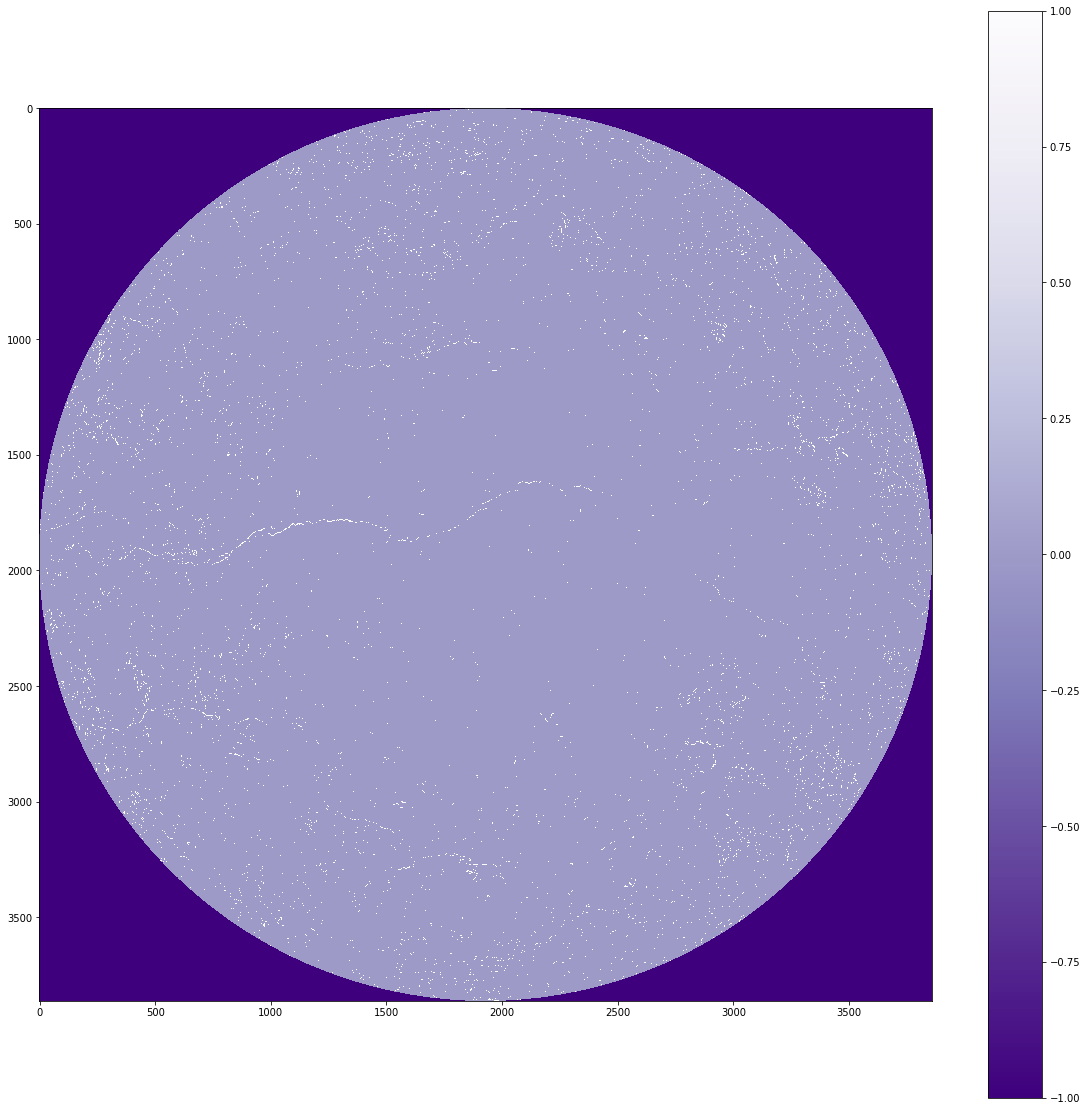

In [164]:
helpers.plot_image(labeled, interpolation='none', cmap='Purples_r')

In [107]:
df = pd.DataFrame(regionprops_table(label(labeled).astype(np.uint8), properties=['convex_area', 'eccentricity', 'label']))

KeyboardInterrupt: 

In [ ]:
df